# Analysis of results of running the OpenCL RAMP model with dynamic calibration of the model parameters

The OpenCL RAMP model is ran with ABC in RunModel_DynamicCalibration.py. The prior distribution of parameters driving the model are based on past knowledge of similar epidemics. The model is run initially for a 14 day window in which the parameters are calibrated using ABC with 10 populations and 100 particles in each population. The posterior parameter distributions are then used as the input to the second window, which then runs for 28 days, with the parameters again being calibrated using ABC with 10 populations and 100 particles. This process of feeding the posteriors back in as the prior in the subsequent window is repeated with the window length increasing by 14 days each time, up until 8 windows have been run, with the final window having a length of 98 days.

This notebook compares the performance of the OpenCL RAMP model ran with dynamic calibration, with the performance of the same model, but ran with one-off calibration of the parameter values. 

For the dynamic calibration, the model is ran in RunModel_DynamicCalibration.py. For each window, a .pkl file is saved which contains the history object for that window. This can be queried to extract the associated parameter values and weights. For the one-off calibration, the model is ran in RunModel_OneShotCalibration.py, and similarly produces a .pkl file which can be queried.

In both cases, the current risk beta value which controls the general transmissability of the disease is set as a constant using the value determined in InitialModelCalibration.ipynb

The following aspects of the model performance are examined:
1. The evolution of the parameter values with dynamic calibration over the course of the pandemic
2. The predictions made by the model within each calibration window
3. The predictions made when the parameter values from the final dynamic calibration window are used to run the model forward in time for X days, where X is equal to 63 days (9 weeks) plus the length of the dynamic calibration window used to define the parameter values, e.g. window 1, 14 days, X = 14 + 63 = 77 days, window 2, 28 days, X = 28 + 63 = 91 days

For 3. the performance of the model using the parameters from the dynamic calibration process at the end of each window are compared to the performance of the model using parameter values from a one-off model calibration. For each dynamic calibration window, the model using parameter values from a one-off model calibration being used for comparison has been calibrated using the same number of days of data as the length of that dynamic calibration window. 

### Set up environment and read in data

#### Set up environment

In [1]:
import pickle
import os
import pyabc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd
import sys
import matplotlib.patches as mpatches   
from matplotlib.ticker import MaxNLocator
import properscoring as ps

# Bespoke RAMP classes for running the model
sys.path.append("../../")
# from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Read in history.pkl objects

In [57]:
history_dict = {}
windows  =7
for window in range(1,windows+1):
    fname = "Outputs/RunModel_DynamicCalibration/abc_history_8windows_window{}, 10pops_100particles_Crb0.019_1656078938.pkl".format(window)
    with open(fname, "rb") as f:
            history = pickle.load(f)
    history_dict["w{}".format(window)]= history 

#### Read in observations data

In [3]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily_raw_values = pd.read_csv("observation_data/daily_cases_devon.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily_raw_values['CumulativeCases'] = cases_devon_daily_raw_values['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily_raw_values['CumulativeCases'].values
    
## Get dataframe with totals for whole of Devon
cases_devon_weekly_raw_values = pd.read_csv("observation_data/weekly_cases_devon.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly_raw_values['CumulativeCases'] = cases_devon_weekly_raw_values['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly_raw_values['CumulativeCases'].values

# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

#### Define prior parameter values

In [4]:
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
work_rv = pyabc.RV("beta", 0.1, 2)
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {"retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv}

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

## 1. The evolution of the parameter values with dynamic calibration over the course of the pandemic

### Prior distribution of each parameter, and the posterior distribution at the end of each window (final population)

/tmp/ipykernel_112486/2728480127.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


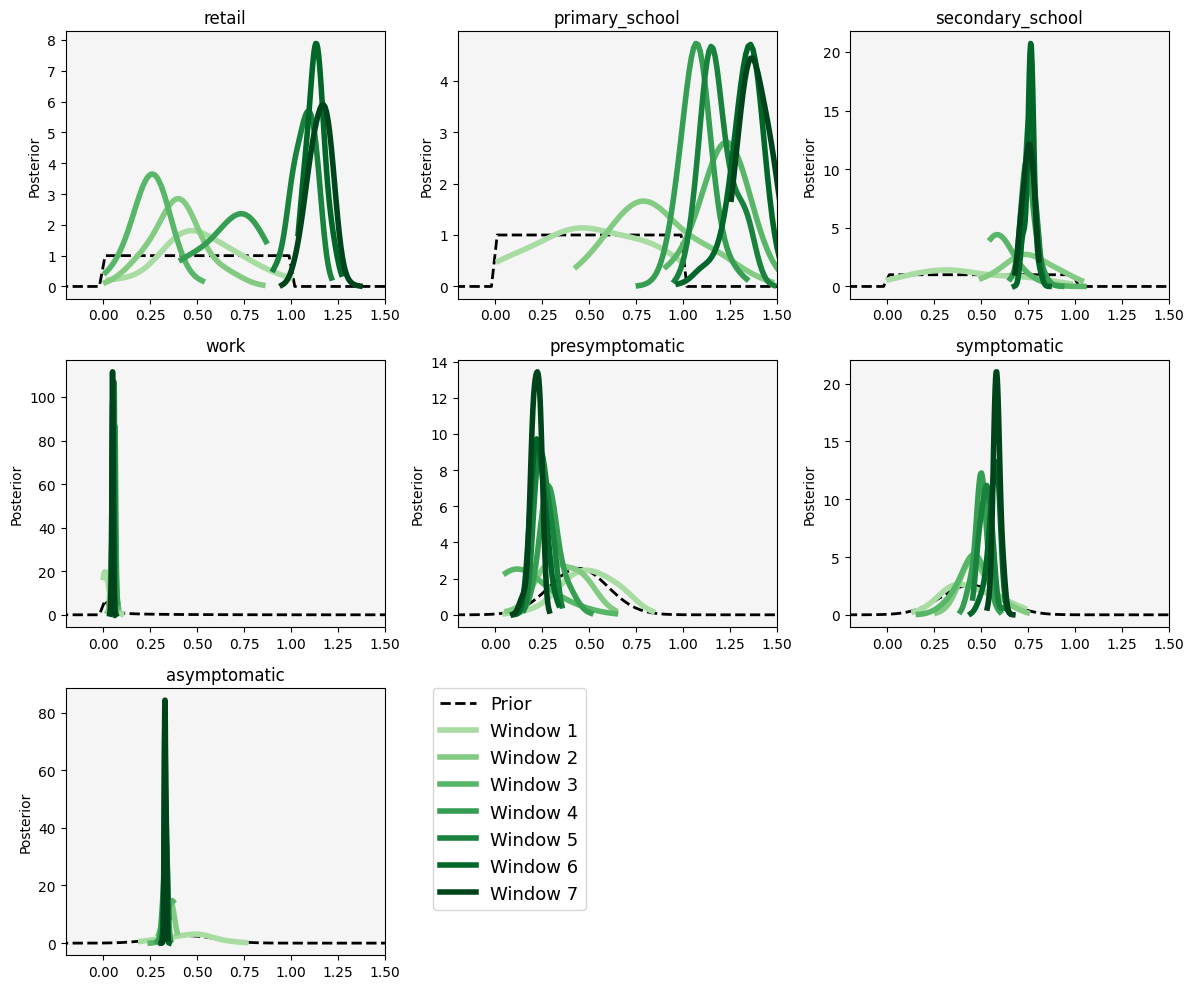

In [5]:
# Define colour map
evenly_spaced_interval = np.linspace(0.35, 1, len(history_dict))
colors = [cm.Greens(x) for x in evenly_spaced_interval]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
# Loop through each parameter, and add a subplot
for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    ax.set_facecolor('whitesmoke')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 2, linestyle ='dashed')
    ax.set_xlim(-0.2, 1.5)
    ax.set_xlabel("Parameter value")
    # Loop through each window and plot the posterior distribution from the final population
    for count, (history_name, history) in enumerate(history_dict.items()):
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, label="Window {}".format(count+1), linewidth = 4, 
                                        color= colors[count], xname = '')
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
# Add legend        
fig.legend(handles, labels, loc='center right', fontsize = 13, bbox_to_anchor=(0.5, 0.195))

# Formatting
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()

fig.tight_layout()
fig.show()

### Prior distribution of each parameter, and the posterior distribution at the end of each window (final population), with the distributions for the intermediate populations as dashed lines

/tmp/ipykernel_112486/2490359998.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


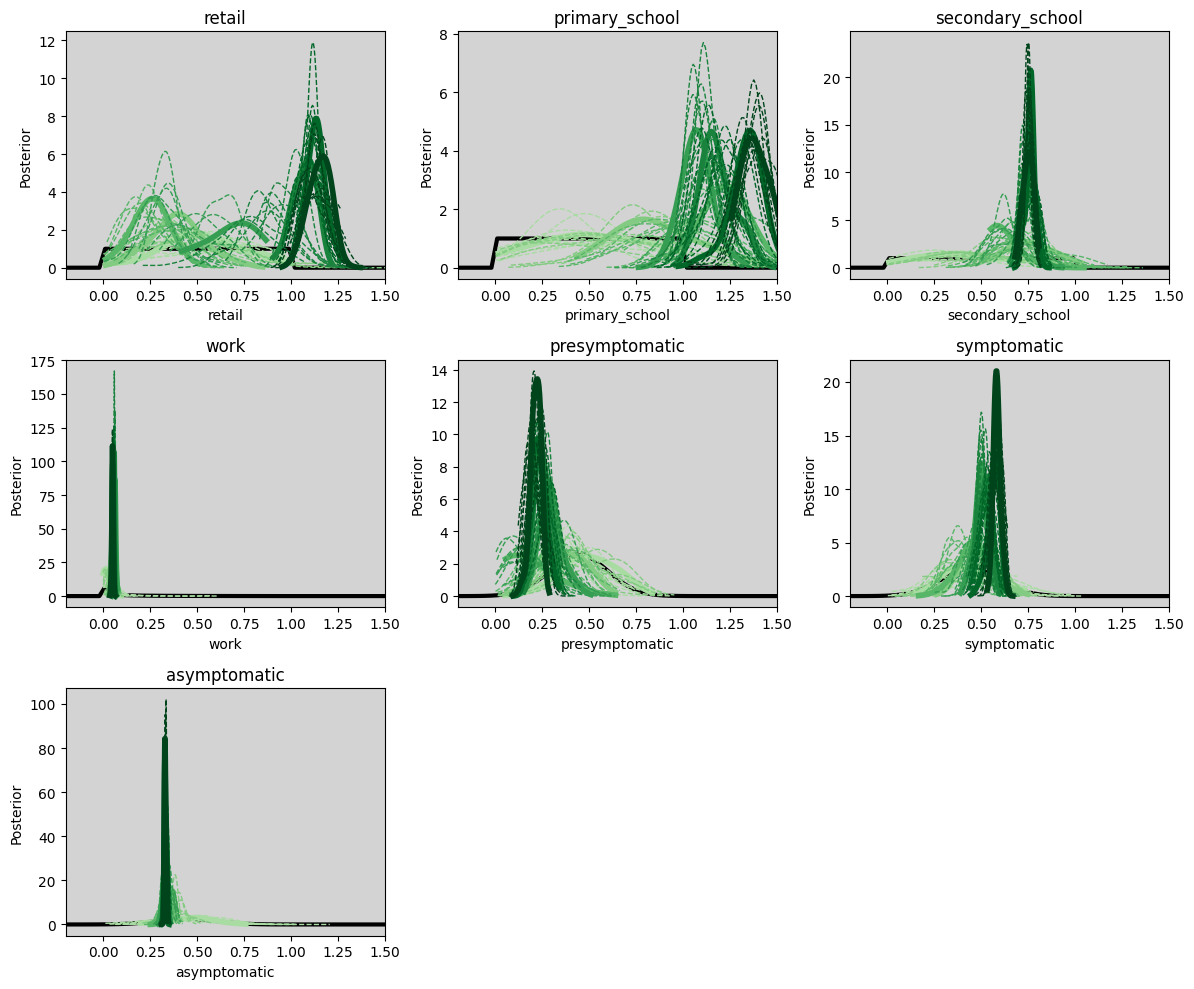

In [6]:
# Define colour map and line style to use in intermediate populations
linestyles = ['dashed'] * history.max_t + ['solid']
linewidths = [1] * history.max_t + [4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
# Loop through each parameter
for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    ax.set_facecolor('lightgray')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black',  linewidth  = 3, linestyle ='solid')
    ax.set_xlim(-0.2, 1.5)
    # Loop through each window
    for count, (history_name, history) in enumerate(history_dict.items()):
        # Loop through each population
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = colors[count], linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
# Formatting        
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

## 2. Assessment of the predictions made by the model within each calibration window

##### Get the model predictions and particle distances for each particle within each dynamic calibration window. Store these in a dictionary

In [7]:
# Create dictionary linking each window name to its length (days)
window_lengths_dict = {}
for count, key in enumerate(history_dict.keys()):
    window_lengths_dict[key]=14*(count+1)

# Create dictionary to store results for each window
abc_sum_stats = {}

# Loop through each calibration window, defining the number of days it covered
for t in range(0,history.n_populations):
    for window, n_days in window_lengths_dict.items():

        # Create lists to store values for each particle
        distance_l, daily_preds_l, params_l = [],[],[]

        # get the history for this window    
        history_wx  = history_dict[window]   

        # Get parameter values
        parameter_vals_df, w = history_wx.get_distribution(m=0, t=t)

        # Get the summary stats for the final population for this window ([1] means keep just the 
        # dataframe and not the array of weights)
        weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=t)[1]
     
        # Loop through each particle and save their distance and predictions into the lists
        for particle_no in range(0,100):
            # Get data for just this particle
            particle_x_dict = weighted_sum_stats_t0[particle_no]

            # Get daily predictions
            cumulative_model_diseased_devon = particle_x_dict["model_daily_cumulative_infections"]     
            cumulative_model_diseased_devon = cumulative_model_diseased_devon[0:n_days]

            # Add daily predictions for this particle to list
            daily_preds_l.append(cumulative_model_diseased_devon)

            # Add distance to list
            distance_l.append(particle_x_dict['distance'])

            # Add parameter values to list
            params_l.append(parameter_vals_df.iloc[particle_no])

        # Add to dictionary for this window
        abc_sum_stats["{}_{}".format(window,t)] = {'distance_l':distance_l, 'daily_preds_l' :daily_preds_l, 'params_l':params_l}

### Compare model predictions from final population within each calibration window to observations
The black lines are the predictions made by each particle in the final population  
The green line is the best particle (the lowest distance between predictions and observations)  
The blue line is the observations

Length of window:  28
mean of all Crps values:  228.52654766587582
mean of first 28 crps values:  228.52654766587582
Length of window:  42
mean of all Crps values:  322.63924205776937
mean of first 28 crps values:  331.7811531559846
Length of window:  56
mean of all Crps values:  467.4215030306167
mean of first 28 crps values:  296.6436852988418
Length of window:  70
mean of all Crps values:  584.0501644075788
mean of first 28 crps values:  278.1657102988417
Length of window:  84
mean of all Crps values:  621.4976708285117
mean of first 28 crps values:  257.2049137687444
Length of window:  98
mean of all Crps values:  605.3936339292197
mean of first 28 crps values:  245.77580203469418


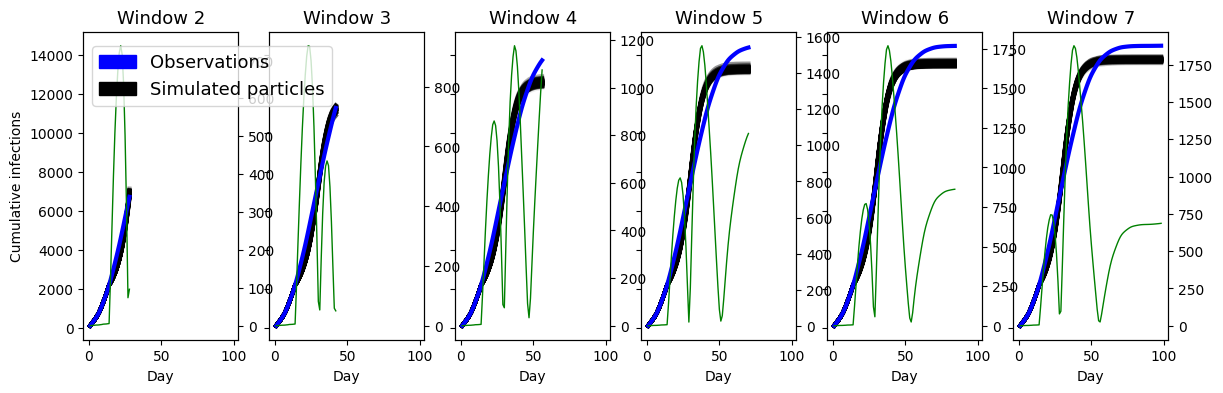

In [263]:
# Create figure
fig, axes = plt.subplots(1, len(window_lengths_dict)-1, figsize=(14,4), sharey = True, sharex=True)

# Create dictionary containing all items except the first item
# This is because the first window is length 14, and the model is seeded for 14 days
# thus the results are identical and the code fails 
windows_length_dict_w2_onwards = dict(list(window_lengths_dict.items())[1:])

# Loop through each window, adding a new subplot
for axes_number, (window, n_days)  in enumerate(windows_length_dict_w2_onwards.items()):
    # Define t (the last timeslice in the window)
    t = history.max_t
    # Get distances and predictions for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # Define x axis for plot (number of days these results relate to)
    x=range(1,n_days+1)    

    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", linewidth = 3, alpha=1-distance_norm[i])  # (1-x because high distance is bad)
    # Add the best particle
    #axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 2,
    #                      label = 'Best particle')  # (1-x because high distance is bad)
    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 3, color="blue")
    
    ### Find CRPS score
    ax2 = axes[axes_number].twinx()
    obs = cases_devon_daily[0:len(daily_preds_l[0])]
    
    crps_vals = []
    for day in range(0,len(daily_preds_l[5])):
       # Predicted values this day
       predictions_this_day = [item[day] for item in daily_preds_l]
       # Find CRPS score
       crps_vals.append(ps.crps_ensemble(obs[day], predictions_this_day))
    ax2.plot(x, crps_vals, label="Observations", linewidth = 1, color="green")
    print("Length of window: ",len(crps_vals))
    print("mean of all Crps values: ", np.mean(crps_vals))
    print("mean of first 28 crps values: ", np.mean(crps_vals[:28]))
      
    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("Window {}".format(axes_number + 2), fontsize = 13)

# Apply legend
# axes[0].legend(fontsize="small")
axes[0].set_ylabel("Cumulative infections")

# # Create patches for legend 
black_patch = mpatches.Patch(color='black', label='Simulated particles')
blue_patch = mpatches.Patch(color='blue', label='Observations')
# orange_patch = mpatches.Patch(color='orange', label='One-off calibration - best particle')
# green_patch = mpatches.Patch(color='green', label='Dynamic calibration - best particle')
plt.legend(handles=[blue_patch, black_patch], loc="lower left", fontsize= 13, bbox_to_anchor=(-6, 0.73));

# Set full plot title
# fig.suptitle('Number of infections predicted by each particle within each window - final population'.format(t))

### Compare model predictions from each population in final calibration window to observations
The black lines are the predictions made by each particle in each population  
The green line is the best particle (the lowest distance between predictions and observations)  
The blue line is the observations

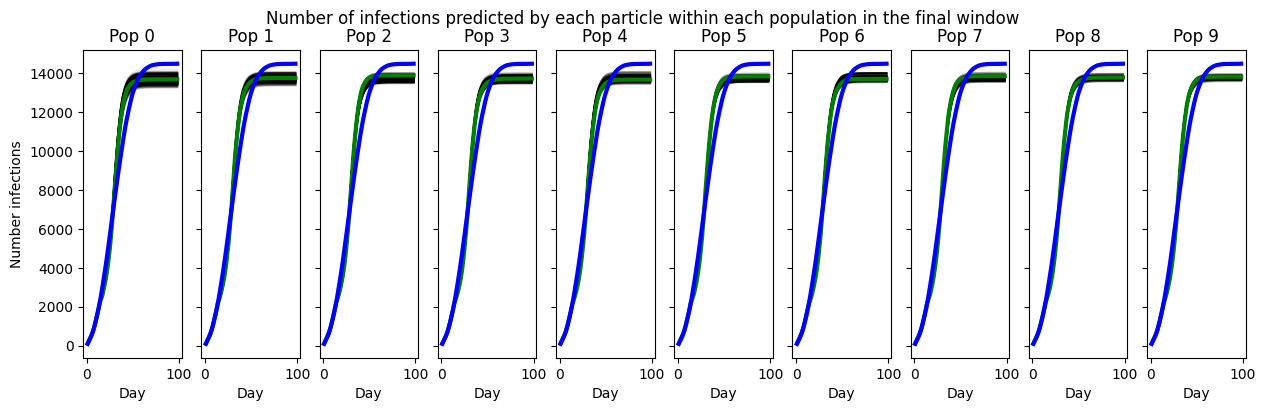

In [9]:
# Create figure
fig, axes = plt.subplots(1, history.max_t+1, figsize=(15,4), sharey=True)

# Loop through each population and plot its data on a subplot
for axes_number, t in enumerate(range(0, history.max_t+1)):
    # Create dictionary containing all items except the first item
    window, n_days = list(window_lengths_dict.items())[-1]
    
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Get data for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # define number of days these results relate to
    x=range(1,n_days+1)    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)
    # Add the best particle
    axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 3,
                          label = 'Best particle')  # (1-x because high distance is bad)
    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 3, color="blue")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("Pop {}".format(t))

axes[0].set_ylabel("Number infections")
# Apply legend
# axes[0].legend(fontsize="large")
    
# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each population in the final window '.format(t));

## 3. Model predictions for the future using parameter values from dynamic calibration

#### a. Run the model forward in time using the posterior parameter distributions from the dynamic calibration windows. For each window, use the model to make predictions for the next 63 days (9 weeks), starting from the end of the calibration window. To achieve this, the model is ran for 11 weeks in total, starting from 14 days before the end of the calibration window (with the first 14 days being seeded using the observed data for this period). So, the model is ran for X days, where X is equal to 77 days (11 weeks) plus the length of the dynamic calibration window used to define the parameter values, e.g. window 1, 14 days, X = 14 + 77 = 105 days, window 2, 28 days, X = 28 + 77 = 119 days

##### Set up OpenCL runner

In [10]:
## Define parameters
ITERATIONS = 77  # Number of days to run for (this is updated later)
NUM_SEED_DAYS = 14  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")

# Define filepath to file containing default parameter values
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

# Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
# re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

# Initialise the class so that its ready to run the model.
OpenCLRunner.init(iterations = ITERATIONS,  repetitions = REPETITIONS,observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH,
     num_seed_days = NUM_SEED_DAYS) 

# Set constants 
current_risk_beta_val =0.019
const_params_dict = { "current_risk_beta": current_risk_beta_val,"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)

/nfs/a319/gy17m2a/Project/RAMP-UA/experiments/calibration/../../microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


##### Use parameter distribution from final population of each window of dynamic calibration to run model for X days, where X is equal to 63 days (11 weeks) plus the length of the dynamic calibration window used to define the parameter values, e.g. window 1, 14 days, X = 14 + 63 = 105 days, window 2, 28 days, X = 28 + 63 = 119 days

In [158]:
# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30

# Create dictionary to store results for each window
windows_dict ={}

# Loop through each window
for window in window_lengths_dict.keys():

    # Define abc_history object from final window
    abc_history = history_dict[window]

    # Get dataframe of posterior parameter values
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

    # Sample from the dataframe of posteriors using KDE
    kde = MultivariateNormalTransition(scaling=1)
    kde.fit(df, w)
    samples = kde.rvs(N_samples)

    # Now run N models and store the results of each one
    distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

    negative_count = 0  # Count the number of negatives returned in the KDE posterior
    for i, sample in samples.iterrows():
        # Check for negatives. If needed, resample
        while (sample < 0).values.any():
            #print("Found negatives. Resampling")
            negative_count += 1
            sample = kde.rvs()
            # Added in this line as the sample was in the wrong format for the while loop
            sample = pd.Series(sample)

        # Create a dictionary with the parameters and their values for this sample
        param_values = sample.to_dict()
        
        # Update the number of days seeding
        length_of_window = int(window.replace('w', '')) * 14
        #OpenCLRunner.update(num_seed_days=length_of_window)
        
        # Update the number of iterations
        iterations = 161 
        
        OpenCLRunner.update(iterations=iterations)       
    
        # Run model
        (_distance, _sim, _obs, _out_params, _summaries) = OpenCLRunner.run_model_with_params_abc(param_values, 
                        return_full_details=True)

        distance_l.append(_distance)
        sim_l.append(_sim)
        obs_l.append(_obs)
        out_params_l.append(_out_params)
        out_calibrated_params_l.append(param_values)
        summaries_l.append(_summaries)
    print(f"Finished sampling. Ignored {negative_count} negative samples.")

    # add to dictionary
    windows_dict[window] = {'distance': distance_l, 'sim': sim_l, 'obs':obs_l, 'summaries': summaries_l, 
                            'out_calibrated_params': out_calibrated_params_l, 'out_params': out_params_l}

Finished sampling. Ignored 15 negative samples.
Finished sampling. Ignored 1 negative samples.
Finished sampling. Ignored 10 negative samples.
Finished sampling. Ignored 0 negative samples.
Finished sampling. Ignored 0 negative samples.
Finished sampling. Ignored 0 negative samples.
Finished sampling. Ignored 0 negative samples.


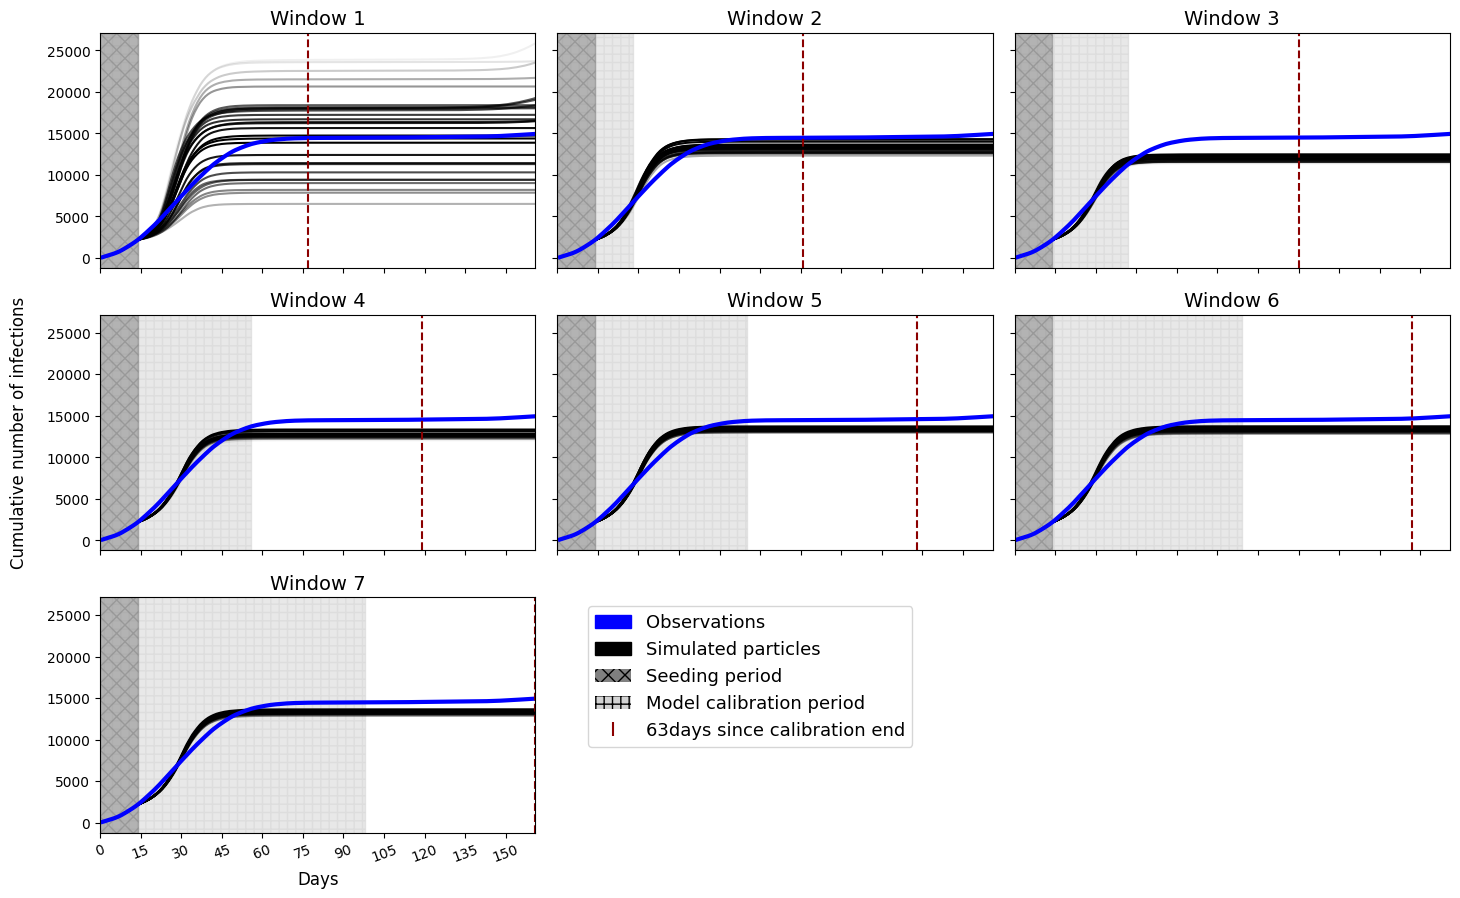

In [493]:
windows= list(window_lengths_dict.keys())

# Create figure
fig, axs = plt.subplots(nrows = 3, ncols = 3,figsize=(15,10), sharey=True, sharex = True)

axs = axs.ravel()

# Loop through each population and plot its data on a subplot
for axes_number, t in enumerate(range(0, 7)):

    # Get the run length associated with this window
    run_length = (axes_number + 1) *14
    end_of_63_days =run_length+63 

    # Read the dictionary for this window
    this_windows_dict = windows_dict[windows[axes_number]]
    
    # Plot model values
    _distance = np.array(this_windows_dict['distance'])  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    x = range(1, len(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][1]))+1)
    ### Dynamic calibration
    # Plot model predictions for each particle in final population            
    for i in range(len(this_windows_dict['summaries'])):
        axs[axes_number].plot(x, OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]),
        color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
    # Plot observations
    axs[axes_number].plot(x, cases_devon_daily[0:len(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]))], label="Observations", linewidth = 3, color="blue")
    # Add a vertical line marking where the seeding period ends
    #axs[axes_number].axvline(x=run_length, color = 'darkred', linestyle = 'solid')
    # Add a vertical line marking where the
    axs[axes_number].axvline(x=end_of_63_days, color = 'darkred', linestyle = 'dashed')
    axs[axes_number].axvspan(0, run_length, alpha=0.5, color='lightgrey', hatch='++')
    axs[axes_number].axvspan(0, 14, alpha=0.5, color='grey',hatch='xx')
    # 
    axs[axes_number].set_xlim([0, len(OpenCLRunner.get_cumulative_daily_infections(windows_dict[windows[-1]]['summaries'][1]))])
    # Control X-ticks
    axs[axes_number].xaxis.set_major_locator(MaxNLocator(15, integer=True))
    axs[axes_number].tick_params(axis='x', rotation=20)
    # Set title
    axs[axes_number].set_title('Window {}'.format(axes_number + 1), fontsize = 14)
    
    # Set axes labels
    fig.supylabel('Cumulative number of infections',x=-0.06)
    if axes_number ==6:
        axs[axes_number].set_xlabel('Days', fontsize = 12)

# Remove last plot's axis
axs[7].axis('off')
axs[8].axis('off')

# Adjust spacing
plt.subplots_adjust(left=0, bottom=0.1, right=0.9,  top=0.9, wspace=0.05, hspace=0.2)

# # Create patches for legend 
black_patch = mpatches.Patch(color='black', label='Simulated particles')
blue_patch = mpatches.Patch(color='blue', label='Observations')
lightgrey_patch = mpatches.Patch(facecolor='lightgrey', hatch='++', label='Model calibration period')
grey_patch = mpatches.Patch(facecolor='grey', hatch='xx', label='Seeding period')

vertical_line = lines.Line2D([], [], color='darkred', marker='|', linestyle='None',
                          markersize=10, markeredgewidth=1.5, label='63days since calibration end')

# green_patch = mpatches.Patch(color='green', label='Dynamic calibration - best particle')
plt.legend(handles=[blue_patch, black_patch,grey_patch,lightgrey_patch,vertical_line], loc="upper left", fontsize= 13, bbox_to_anchor=(-1, 1)); 

## Calculate forecast scores
### Out-of-sample predictions: CRPS scores
Find CRPS scores for the forward predictions made with the paramater posteriors produced at the end of each window.  
Tried several different approaches:
  - For 63 days after the end of the window
  - Always up to day 161 (exlcuding the seeding period)
  - Always up to day 161 (excluding the window period)

### For each 14 day period

In [464]:
chunk_starts = [i for i in range(0, 163, 14)]
chunk_ends = [i for i in range(14, 1177, 14)]

overall_scores_ls = []
scores_dict= {}

################################################################################
# List to store the CRPS score for each window
################################################################################
crps_scores_afterseeding = []
crps_scores_63days = []
crps_scores_afterwindow = []

################################################################################
# Specify the windows
################################################################################
windows = ['w1', 'w2','w3','w4', 'w5', 'w6','w7']

################################################################################
# Loop through the results for each window
################################################################################
for window in windows:
    # print(window)
    this_window_scores_ls = []
    ################################################################################
    # Get the daily predictions from the weekly predictions, and trim daily obs to correct length
    ################################################################################
    this_windows_dict = windows_dict[window]
    forecasts_daily_ls = []
    for i in range(len(this_windows_dict['summaries'])):
        forecasts_daily_ls.append(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]))
    observations_daily = cases_devon_daily[0:(len(forecasts_daily[0]))]
    
    ################################################################################   
    # Convert the format (into list of lists?) as needed for crps_ensemble        
    ################################################################################    
    forecasts_daily= np.stack(forecasts_daily_ls)
    observations_daily=np.stack(observations_daily)
    
    # Repeat 30 times (so there is an observations array for each particle forecast)
    observations_daily = [observations_daily for i in range(30)]
    
    ################################################################################
    # Find the CRPS score for each 14 day chunk
    ################################################################################    
    # Find how many 14 day chunks there are
    chunks = int(int(window.replace('w', '')))
    # For each of these chunks:
    # If it's during the window period then set to a '-'
    for chunk_num in range (0,11):
        if chunk_num < chunks:
            this_window_scores_ls.append('-')
        else:
            # print("Chunk number:", chunk_num, "starts at :", chunk_starts[chunk_num], "ends at: ",chunk_ends[chunk_num])
            # Trim the obs and predictions to include just the data from this chunk
            obs_trimmed =  [item[chunk_starts[chunk_num]:chunk_ends[chunk_num]] for item in observations_daily]
            forecasts_daily_trimmed = [item[chunk_starts[chunk_num]:chunk_ends[chunk_num]] for item in forecasts_daily]
            # Find the score across the ensemble of predictions for this time chunk
            crps_array = ps.crps_ensemble(obs_trimmed, forecasts_daily_trimmed)
            mean_crps = np.mean(crps_array)
            # Add to list of scores for this window
            this_window_scores_ls.append(mean_crps)
            
    # Add scores to dictionary
    scores_dict[window]=this_window_scores_ls
    
################################################################################
# Create dataframe of scores for each 14 day chunk (infilling with NAs)
################################################################################  
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in scores_dict.items() })
dict_df.index = ['D1-14','D15-28', 'D29-42', 'D43-56', 'D57-70','D71-84','D85-98', 'D99-112','D113-126','D127-140',
                'D141-154']
dict_df

,w1,w2,w3,w4,w5,w6,w7
D1-14,-,-,-,-,-,-,-
D15-28,987.709349,-,-,-,-,-,-
D29-42,4626.418765,1485.172036,-,-,-,-,-
D43-56,4768.178434,666.71895,1050.46372,-,-,-,-
D57-70,4428.026646,995.491193,2294.825006,1556.219768,-,-,-
D71-84,4365.681621,1255.803799,2577.228561,1835.882846,1145.805227,-,-
D85-98,4363.159518,1282.761931,2604.328598,1862.83717,1172.422884,1199.706693,-
D99-112,4360.957887,1304.611993,2626.221041,1884.632946,1194.277232,1221.534851,1247.837232
D113-126,4355.222276,1351.695287,2673.30862,1931.691954,1241.361954,1268.621954,1294.853382
D127-140,4357.299381,1398.959761,2720.573094,1978.953094,1288.626428,1315.886428,1342.098332


### Using daily data

In [401]:
################################################################################
# List to store the CRPS score for each window
################################################################################
crps_scores_afterseeding = []
crps_scores_63days = []
crps_scores_afterwindow = []

################################################################################
# Specify the windows
################################################################################
windows = ['w1', 'w2','w3','w4', 'w5', 'w6','w7']

################################################################################
# Loop through the results for each window
################################################################################
for window in windows:

    ################################################################################
    # Get the daily predictions from the weekly predictions, and trim daily obs to correct length
    ################################################################################
    this_windows_dict = windows_dict[window]
    forecasts_daily_ls = []
    for i in range(len(this_windows_dict['summaries'])):
        forecasts_daily_ls.append(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]))
    observations_daily = cases_devon_daily[0:(len(forecasts_daily[0]))]
    
    ################################################################################   
    # Convert the format (into list of lists?) as needed for crps_ensemble        
    ################################################################################    
    forecasts_daily= np.stack(forecasts_daily_ls)
    observations_daily=np.stack(observations_daily)
    
    # Repeat 30 times (so there is an observations array for each particle forecast)
    observations_daily = [observations_daily for i in range(30)]
    # print("Forecasts length: ",len(forecasts_daily[0]), "Obs length: ",len(observations_daily[0]))
    
    ################################################################################
    # Find CRPS score for period from end of seeding period -> end (Day 161)
    ################################################################################
    # Remove the data from within the seeding period
    day_no_end_of_seeding = 14
    observations_afterseeding =  [item[week_no_end_of_training_window:] for item in observations_daily]
    forecasts_afterseeding =  [item[week_no_end_of_training_window:] for item in forecasts_daily]
        
    crps_array_afterseeding = ps.crps_ensemble(observations_afterseeding, forecasts_afterseeding)
    mean_crps_afterseeding = np.mean(crps_array_afterseeding)
    crps_scores_afterseeding.append(mean_crps_afterseeding) 
    
    ################################################################################
    # Find the CRPS score for period from end of training window -> end (Day 161)
    ################################################################################    
    # Remove the data from within the training window period
    day_no_end_of_training_window = int(int(window.replace('w', '')) * 14)
    observations=  [item[day_no_end_of_training_window:] for item in observations_daily]
    forecasts =  [item[day_no_end_of_training_window:] for item in forecasts_daily]
    # print(len(observations[0]))
    crps_array = ps.crps_ensemble(observations, forecasts)
    mean_crps = np.mean(crps_array)
    crps_scores_63days.append(mean_crps) 
    
    ################################################################################
    # Find the CRPS score for the 63 days after the end of the training window period
    ################################################################################    
    observations_63days =  [item[:63] for item in observations]
    forecasts_63days =  [item[:63] for item in forecasts]

    crps_array_63days = ps.crps_ensemble(observations_63days, forecasts_63days)
    mean_crps_63days = np.mean(crps_array_63days)
    crps_scores_afterwindow.append(mean_crps_63days) 
    

df=pd.DataFrame({'Window': windows,'EndOfTrainingWindow+63Days':crps_scores_63days, 'EndOfTrainingWindow-Day161':crps_scores_afterwindow,
                "EndOfSeeding-Day161":crps_scores_afterseeding})
df

,Window,EndOfTrainingWindow+63Days,EndOfTrainingWindow-Day161,EndOfSeeding-Day161
0,w1,4118.899308,3776.522179,4118.899308
1,w2,1273.226919,1120.756039,1204.307512
2,w3,2456.918755,2185.629338,2108.132226
3,w4,1903.286474,1799.725862,1562.230126
4,w5,1266.374539,1198.325262,1090.268407
5,w6,1315.560128,1265.188216,1104.035826
6,w7,1367.527875,1367.527875,1117.330537


### Using weekly data

In [413]:
################################################################################
# List to store the CRPS score for each window
################################################################################
crps_scores_afterseeding = []
crps_scores_63days = []
crps_scores_afterwindow = []

################################################################################
# Specify the windows
################################################################################
windows = ['w1', 'w2','w3','w4', 'w5', 'w6','w7']

################################################################################
# Loop through the results for each window
################################################################################
for window in windows:
    # print(window)
    ################################################################################
    # Get the predictions & observations:
    # - These are lists of arrays, each with X weeks of preds/obs (depending on which window)
    # - Convert the format (into list of lists?) as needed for crps_ensemble
    ################################################################################
    forecasts =  windows_dict[window]['sim']
    observations = windows_dict[window]['obs']
    forecasts= np.stack(forecasts)
    observations= np.stack(observations)
    # print("Forecasts length: ",len(forecasts[0]), "Obs length: ",len(observations[0]))
    # print(observations[0])
    
    ################################################################################
    # Remove the data from within the seeding period
    ################################################################################
    week_no_end_of_seeding = 2
    observations_afterseeding =  [item[week_no_end_of_training_window:] for item in observations]
    forecasts_afterseeding =  [item[week_no_end_of_training_window:] for item in forecasts]
        
    crps_array_afterseeding = ps.crps_ensemble(observations_afterseeding, forecasts_afterseeding)
    mean_crps_afterseeding = np.mean(crps_array_afterseeding)
    crps_scores_afterseeding.append(mean_crps_afterseeding) 
    
    ################################################################################
    # Remove the data from within the training window period
    ################################################################################
    week_no_end_of_training_window = int(int(window.replace('w', '')) * 14/7)
    observations=  [item[week_no_end_of_training_window:] for item in observations]
    forecasts =  [item[week_no_end_of_training_window:] for item in forecasts]
    # print(observations[0])
    
    ################################################################################
    # Find the CRPS score for the 63 days after the end of the training window period
    ################################################################################    
    observations_63days =  [item[:9] for item in observations]
    forecasts_63days =  [item[:9] for item in forecasts]
    # print(observations_63days[0])

    crps_array_63days = ps.crps_ensemble(observations_63days, forecasts_63days)
    mean_crps_63days = np.mean(crps_array_63days)
    crps_scores_afterwindow.append(mean_crps_63days) 
    
    ################################################################################
    # Find the CRPS score for the time period up to 161 days (not including days within training window)
    ################################################################################    
    # print(len(observations[0]))
    crps_array = ps.crps_ensemble(observations, forecasts)
    mean_crps = np.mean(crps_array)
    crps_scores_63days.append(mean_crps) 

df=pd.DataFrame({'Window': windows,'EndOfTrainingWindow+63Days':crps_scores_63days, 'EndOfTrainingWindow-Day161':crps_scores_afterwindow,
                "EndOfSeeding-Day161":crps_scores_afterseeding})
df

,Window,EndOfTrainingWindow+63Days,EndOfTrainingWindow-Day161,EndOfSeeding-Day161
0,w1,4206.578511,3967.386879,4392.701421
1,w2,1291.231041,1151.696483,1213.446303
2,w3,2524.111386,2303.351782,2320.177903
3,w4,1922.906889,1822.478141,1788.614250
4,w5,1270.620353,1193.596296,1232.859334
5,w6,1320.176933,1261.103345,1297.890609
6,w7,1375.802380,1375.802380,1346.417539


### In-sample predictions: Find the CRPS score for each 2 week 'chunk' of time
This allows direct comparison of the accuracy of different parts of the forecast between different windows (comparing the whole forecast would be biased as the whole forecast in each window has a different length)

To do this:
- Calculate how many 14 days chunks there are within the window (e.g. for window 2 - there are 2 chunks)
- For each chunk:
    - Get the forecast and observations for just this 14 day chunk
    - Calculate the CRPS score over all of the 30 forecasts
    - Save it to a list

In [517]:
## This is for splitting the data into 14 day chunks
chunk_starts = [i for i in range(0, 105, 14)]
chunk_ends = [i for i in range(14, 105, 14)]

################################################################################
# Get observations in required format (e.g. from end of seeding period onwards)
################################################################################
obs = cases_devon_daily[0:(len(abc_sum_stats['w7_9'.format(t)]['daily_preds_l'][0]))]
# Convert format
obs= np.stack(obs)
# Repeat 100 times (so there is an observations array for each particle forecast)
obs = [obs for i in range(100)]
# Filter out first 14 days (as these are seeding days so all the same)
obs = [item[14:] for item in obs]

################################################################################
# Make a list to store the overall CRPS over the whole window, for each window
# And make a dictionary to store the list of CRPS scores for each 'chunk' of time, for each window
################################################################################
overall_scores_ls = []
scores_dict= {}

################################################################################
# For each window, take the predictions from day 15 onwards (post seeding)
# Find the CRPS score for the whole rest of the window
# FInd the CRPS score for each 14 day 'chunk' of time
################################################################################
# For window in windows (not the first one as the whole thing is seeding so calculating score is pointless)
for window_num in range(2, 8):
    # print("Window" , window_num)
    # Create a list to store the scores for each 14 day chunk for this window
    this_window_scores_ls = []
    
    ################################################################################
    # Get this window's results in correct format (e.g. from end of seeding period onwards)
    ################################################################################
    this_windows_results = abc_sum_stats['w{}_9'.format(window_num)]
    # Get daily predictions (for each of 100 particles)
    this_windows_daily_preds = this_windows_results['daily_preds_l'].copy()
    # Filter out first 14 days (as these are seeding days so all the same)
    this_windows_daily_preds = [item[14:] for item in this_windows_daily_preds]
    # print("length of predictions (not incl seeding): ", len(this_windows_daily_preds[0]))
    #print(len(this_windows_daily_preds[0]))
    ################################################################################
    # Trim observations to keep just the bit that is same length as preds
    ################################################################################
    # print("original length of obs: ", len(obs[0]))
    obs_trimmed = [item[:len(this_windows_daily_preds[0])] for item in obs]
    
    ################################################################################
    # Find the CRPS score for the whole window
    ################################################################################    
    # print("obs after trimming: ", len(obs_trimmed[0]))
    crps_array = ps.crps_ensemble(obs_trimmed, this_windows_daily_preds)
    mean_crps = np.mean(crps_array)
    overall_scores_ls.append(mean_crps)
    
    # Print out the length
    # print("length of this window:", len(this_windows_daily_preds[0]))
        
    ################################################################################
    # Find the CRPS score for each 14 day chunk
    ################################################################################    
    # Find how many 14 day chunks there are
    chunks = window_num-1
    # print("Number of chunks", chunks)
    # For each of these chunks:
    for chunk_num in range (0,chunks):
        # print("Chunk number:", chunk_num, "starts at :", chunk_starts[chunk_num], "ends at: ",chunk_ends[chunk_num])
        # Trim the obs and predictions to include just the data from this chunk
        obs_trimmed =  [item[chunk_starts[chunk_num]:chunk_ends[chunk_num]] for item in obs]
        this_windows_daily_preds_trimmed = [item[chunk_starts[chunk_num]:chunk_ends[chunk_num]] for item in this_windows_daily_preds]
        # Find the score across the ensemble of predictions for this time chunk
        crps_array = ps.crps_ensemble(obs_trimmed, this_windows_daily_preds_trimmed)
        mean_crps = np.mean(crps_array)
        # Add to list of scores for this window
        this_window_scores_ls.append(mean_crps)
        
    # Add scores to dictionary
    scores_dict[window_num]=this_window_scores_ls
    
################################################################################
# Create dataframe of scores for each 14 day chunk (infilling with NAs)
################################################################################  
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in scores_dict.items() })
dict_df.columns = windows[1:]
dict_df.index = ['D15-28', 'D29-42', 'D43-56', 'D57-70','D71-84','D85-98' ]
dict_df

14
28
42
56
70
84


,w2,w3,w4,w5,w6,w7
D15-28,484.659502,683.383555,619.224270,578.242127,539.243377,516.318868
D29-42,NaN,366.597184,854.654905,1139.186304,1319.830891,1409.034798
D43-56,NaN,NaN,570.553987,485.670878,592.330281,710.032589
D57-70,NaN,NaN,NaN,907.655720,616.850720,430.906445
D71-84,NaN,NaN,NaN,NaN,889.252370,699.767370
D85-98,NaN,NaN,NaN,NaN,NaN,725.581217


### Overall score for whole forecast

In [520]:
times = [2,4,6,8,10,12]
import math
overall_scores_df =pd.DataFrame(overall_scores_ls, )
overall_scores_df['Days'] = [14,28,42,56,70,84]
overall_scores_df['NormalisedScore'] = [int(b) / math.sqrt(m) for b,m in zip(overall_scores_ls, overall_scores_df['Days'])]
overall_scores_df.index = windows[1:]
overall_scores_df = overall_scores_df.rename(columns ={0:'Score'})
overall_scores_df 

,Score,Days,NormalisedScore
w2,484.659502,14,129.354441
w3,524.990370,28,99.026692
w4,681.477720,42,105.080581
w5,777.688757,56,103.830992
w6,791.501528,70,94.542583
w7,748.606881,84,81.613491
